In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
def standardization(x):
    z = (x - min(x))/(max(x) - min(x))
    return(z)

In [12]:
def aggdata(b='_inbound', out='data'):
    # data is from https://github.com/dongmeic/BikeCounting/blob/main/BikeCounts/Explore_Bikes_On_Buses.ipynb
    data = pd.read_csv('T:/Tableau/tableauBikesOnBuses/Datasources/AggregatedBikesOnBuses' + b + '.csv')
    aggdata = data.groupby("Location").agg({"Counts": "mean", "Growth": lambda x: x.dropna().mean()})
    aggdata = {'Location':aggdata.index.values,
               'Counts':aggdata.Counts.values,
               'Growth':aggdata.Growth.values}
    aggdata = pd.DataFrame(aggdata)
    locdata = data[['Location', 'Latitude', 'Longitude', 'Route']].drop_duplicates(ignore_index=True)
    outdata = locdata.merge(aggdata, how='inner', on='Location')
    gdf = gpd.GeoDataFrame(outdata, geometry=gpd.points_from_xy(outdata.Longitude, outdata.Latitude))
    gdf = gdf.set_crs("EPSG:4326")
    gdf = gdf.to_crs("EPSG:3857")
    
    if out == 'data':
        return(data)
    else:
        gdf.to_file("T:/DCProjects/StoryMap/BikeCounting/BikeCounts/Output/Bikes_on_Buses" + b + ".shp")
        return(gdf)

In [7]:
data = aggdata()

In [8]:
data.Location.values[0:3]

array(['"E" Street Station', '"Q" Street Station outbound',
       '(^) S/S of Hwy 58 E of Pleasant Hill'], dtype=object)

In [9]:
data[data.Location.isin(data.Location.values[0:4])]

,Location,Year,Counts,Latitude,Longitude,Growth,Route
0,"""E"" Street Station",2013,31,44.050917,-123.022074,NaN,EmX
1,"""Q"" Street Station outbound",2013,21,44.063325,-123.026245,NaN,EmX
2,(^) S/S of Hwy 58 E of Pleasant Hill,2020,1,43.969440,-122.938802,0.0,92
3,(^) S/S of Hwy 58 E of Pleasant Hill,2015,1,43.969440,-122.938802,0.0,92
4,(^) S/S of Hwy 58 E of Pleasant Hill,2014,1,43.969440,-122.938802,NaN,92


In [23]:
data[data.Year==2013]

,Location,Year,Counts,Latitude,Longitude,Growth,Route
0,"""E"" Street Station",2013,31,44.050917,-123.022074,NaN,EmX
1,"""F"" Street Station",2013,14,44.051184,-123.023222,NaN,EmX
2,"""Q"" Street Station inbound",2013,50,44.062770,-123.026156,NaN,EmX
3,"""Q"" Street Station outbound",2013,21,44.063325,-123.026245,NaN,EmX
8,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2013,12,44.135869,-122.613404,NaN,91
...,...,...,...,...,...,...,...
14298,W/S of Willamette S of 29th,2013,69,44.025703,-123.090799,NaN,73
14299,W/S of Willamette S of 29th,2013,69,44.025703,-123.090799,NaN,24
14310,W/S of Willamette S of 36th,2013,3,44.016119,-123.092550,NaN,73
14323,W/S of Wilshire N of Windsor Circle,2013,4,44.030527,-123.147638,NaN,78


In [10]:
data.Growth.dropna().mean()

0.23670369881913514

In [11]:
outdata.head()

,Location,Latitude,Longitude,Route,Counts,Growth
0,"""E"" Street Station",44.050917,-123.022074,EmX,31.000,NaN
1,"""F"" Street Station",44.051184,-123.023222,EmX,14.000,NaN
2,"""Q"" Street Station inbound",44.062770,-123.026156,EmX,50.000,NaN
3,"""Q"" Street Station outbound",44.063325,-123.026245,EmX,21.000,NaN
4,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,44.135869,-122.613404,91,10.125,0.504481


In [19]:
MPOBound = gpd.read_file("V:/Data/Transportation/MPO_Bound.shp")

In [46]:
ngdf = gdf[~gdf["Location"].str.contains('|'.join(["Springfield Station", "Eugene Station"]))]

In [48]:
ngdf.to_file(r"T:\DCProjects\StoryMap\BikeCounting\BikeCounts\Output\Bikes_on_Buses_excluded.shp")

In [26]:
values = standardization(gdf.Counts) * 1000

In [35]:
MPOBound

,Area,inside_mpo,is_in_mpo,geometry
0,125.303,Y,1,"POLYGON ((-13702033.591 5490268.024, -13700318..."


In [36]:
pip = gdf.within(MPOBound.loc[0, 'geometry'])

In [37]:
pnts = gdf.loc[pip].copy()

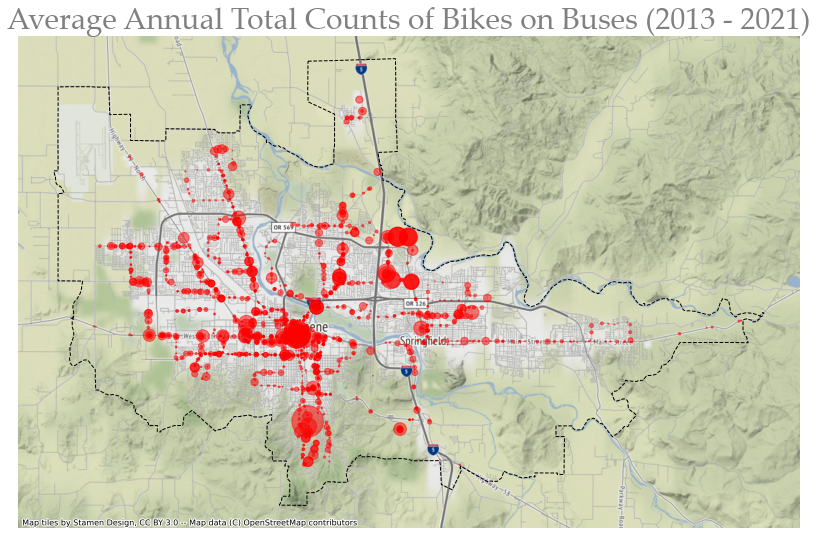

In [39]:
fig, ax = plt.subplots(figsize=(14, 12))
pnts.plot(ax=ax, marker='o', markersize=values, color='red', alpha=.5, legend=True, aspect=1)
MPOBound.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', aspect=1)
ctx.add_basemap(ax)
plt.title("Average Annual Total Counts of Bikes on Buses (2013 - 2021)", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [13]:
gdf = aggdata(b='_inbound', out='gdf')